In [40]:
from utils import *
from chess_feature_extractors import *
import matplotlib.pyplot as plt
from IPython.display import SVG, display
import chess.svg
board_feats_disagreements = pd.read_csv("../random_set_disagreement.csv")
games_df = pd.read_csv("../RandomScored-set.csv")
unique_games_df = games_df.drop_duplicates(subset='game')
grouped_df = unique_games_df.groupby('game')['result'].value_counts().unstack(fill_value=0)
total_wins = grouped_df['win'].sum()
total_losses = grouped_df['lose'].sum()
total_draws = grouped_df['draw'].sum()
win_percent = total_wins / (total_wins + total_draws + total_losses) * 100
print(f"Total wins number: {total_wins}\n"
      f"Total losses number: {total_losses}\n"
      f"Total draws number: {total_draws}")
print(f"Win percent: {win_percent.__round__(3)}%")

Total wins number: 2921
Total losses number: 4384
Total draws number: 758
Win percent: 36.227%


In [41]:
grouped_df = games_df.groupby('game')['contributor'].value_counts().unstack(fill_value=0)
grouped_df['moves_num'] = grouped_df['agreed'] + grouped_df['leela10b2500'] + grouped_df['maia1200']
grouped_df['agreed_percent'] = ((grouped_df['agreed'] / grouped_df['moves_num']) * 100).__round__(3)
grouped_df['leela_percent'] = ((grouped_df['leela10b2500'] / grouped_df['moves_num']) * 100).__round__(3)
grouped_df['maia_percent'] = ((grouped_df['maia1200'] / grouped_df['moves_num']) * 100).__round__(3)

print(f"Average percent of agreed moves in a game: {grouped_df['agreed_percent'].mean().__round__(3)}%, variance: {grouped_df['agreed_percent'].var().__round__(3)}")
print(f"Average percent of Leela moves in a game: {grouped_df['leela_percent'].mean().__round__(3)}%, variance: {grouped_df['leela_percent'].var().__round__(3)}")
print(f"Average percent of Maia moves in a game: {grouped_df['maia_percent'].mean().__round__(3)}%, variance: {grouped_df['maia_percent'].var().__round__(3)}")

Average percent of agreed moves in a game: 56.397%, variance: 98.567
Average percent of Leela moves in a game: 21.808%, variance: 55.349
Average percent of Maia moves in a game: 21.795%, variance: 52.749


General statistics of the scores and confidence for each bot:

In [42]:
disagreement_df = games_df[games_df['contributor'].isin(['maia1200', 'leela10b2500'])]
selected = ['maia1200_eval', 'maia1200_conf', 'leela10b2500_eval', 'leela10b2500_conf']
conf_eval = disagreement_df[selected]
conf_eval.describe()

,maia1200_eval,maia1200_conf,leela10b2500_eval,leela10b2500_conf
count,153882.000000,153882.000000,153882.000000,153882.000000
mean,0.449591,0.873391,0.500200,0.850710
std,0.359317,0.174876,0.357992,0.186381
min,0.000000,0.200000,0.000000,0.200000
25%,0.120000,0.800000,0.160000,0.800000
50%,0.400000,1.000000,0.500000,1.000000
75%,0.780000,1.000000,0.840000,1.000000
max,1.000000,1.000000,1.000000,1.000000


Now we'll calculate the Pearson correlation between eval and confidence for each bot:

In [43]:
correlation_matrix = disagreement_df.corr()
maia_conf_eval_correlation = correlation_matrix.loc['maia1200_conf', 'maia1200_eval']
print(f"Correlation between Maia confidence and eval: {maia_conf_eval_correlation.__round__(3)}")
leela_conf_eval_correlation = correlation_matrix.loc['leela10b2500_conf', 'leela10b2500_eval']
print(f"Correlation between Leela confidence and eval: {leela_conf_eval_correlation.__round__(3)}")

Correlation between Maia confidence and eval: 0.075
Correlation between Leela confidence and eval: 0.084


/var/folders/c_/fhx1wcfx75v13kxh3lwr6jrc0000gn/T/ipykernel_14876/2137939842.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = disagreement_df.corr()


In [44]:
maia_conf_move_correlation = correlation_matrix.loc['maia1200_conf', 'ply']
maia_eval_move_correlation = correlation_matrix.loc['maia1200_eval', 'ply']
leela_conf_move_correlation = correlation_matrix.loc['leela10b2500_conf', 'ply']
leela_eval_move_correlation = correlation_matrix.loc['leela10b2500_eval', 'ply']

print(f"Correlation between Maia confidence and move number: {maia_conf_move_correlation.__round__(3)}")
print(f"Correlation between Maia eval and move number: {maia_eval_move_correlation.__round__(3)}")
print(f"Correlation between Leela confidence and move number: {leela_conf_move_correlation.__round__(3)}")
print(f"Correlation between Leela eval and move number: {leela_eval_move_correlation.__round__(3)}")

Correlation between Maia confidence and move number: 0.085
Correlation between Maia eval and move number: -0.019
Correlation between Leela confidence and move number: -0.085
Correlation between Leela eval and move number: -0.12


In [45]:
disagreement_df['dis_num'] = 0
cur_game = -1
cur_count = 1
for ind, row in disagreement_df.iterrows():
    cur_count += 1
    if row['game'] != cur_game:
        cur_game = row['game']
        cur_count = 1
    disagreement_df.loc[ind, 'dis_num'] = cur_count

/var/folders/c_/fhx1wcfx75v13kxh3lwr6jrc0000gn/T/ipykernel_14876/2503335194.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disagreement_df['dis_num'] = 0


Text(0.5, 1.0, 'Histogram of Disagreements Numbers')

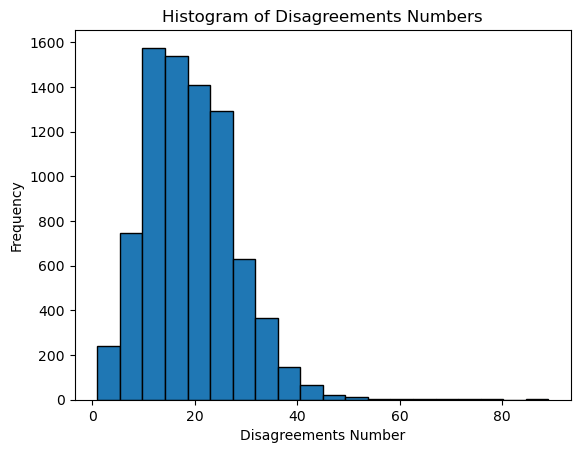

In [46]:
max_dis_per_game = disagreement_df.groupby('game')['dis_num'].max()
plt.hist(max_dis_per_game, bins=20, edgecolor='black')
plt.xlabel('Disagreements Number')
plt.ylabel('Frequency')
plt.title('Histogram of Disagreements Numbers')

In [47]:
disagreement_df['dis_in_game'] = disagreement_df['game'].map(max_dis_per_game)

/var/folders/c_/fhx1wcfx75v13kxh3lwr6jrc0000gn/T/ipykernel_14876/4267267249.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disagreement_df['dis_in_game'] = disagreement_df['game'].map(max_dis_per_game)


/var/folders/c_/fhx1wcfx75v13kxh3lwr6jrc0000gn/T/ipykernel_14876/4261565581.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_range_16_22 = df_range_16_22[disagreement_df['dis_in_game'] > 15]


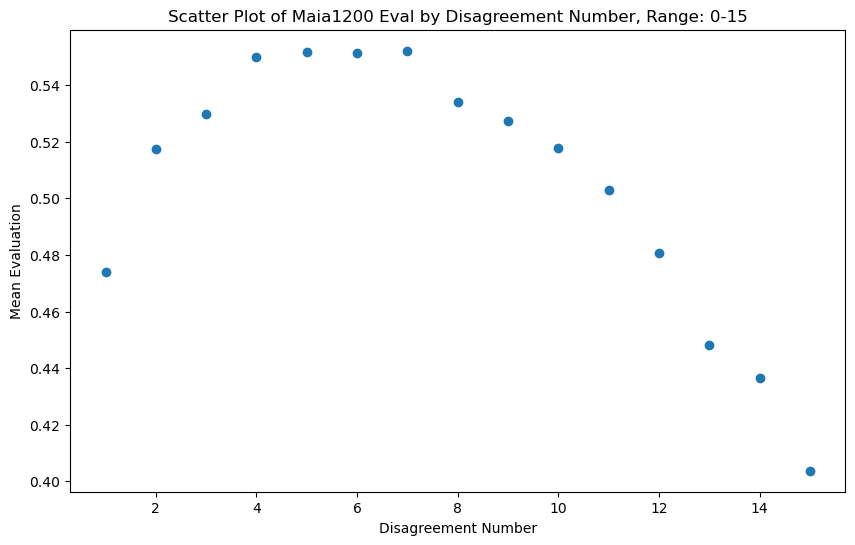

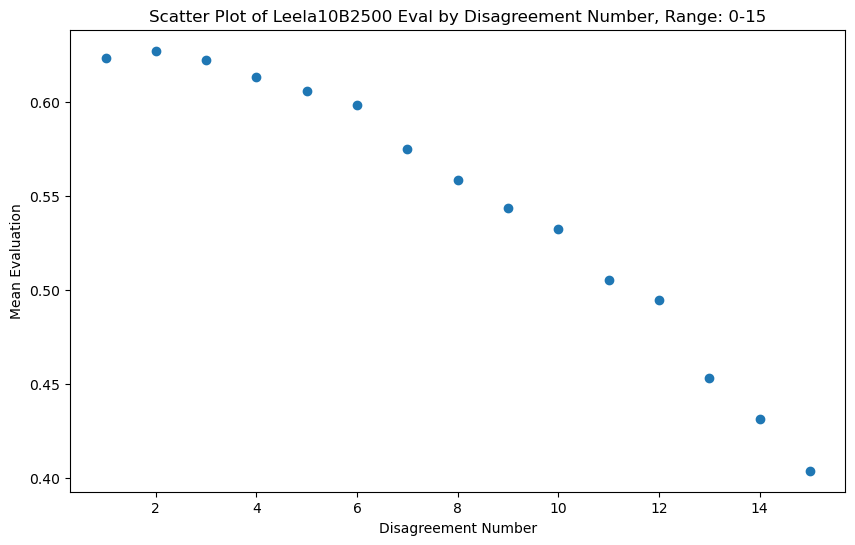

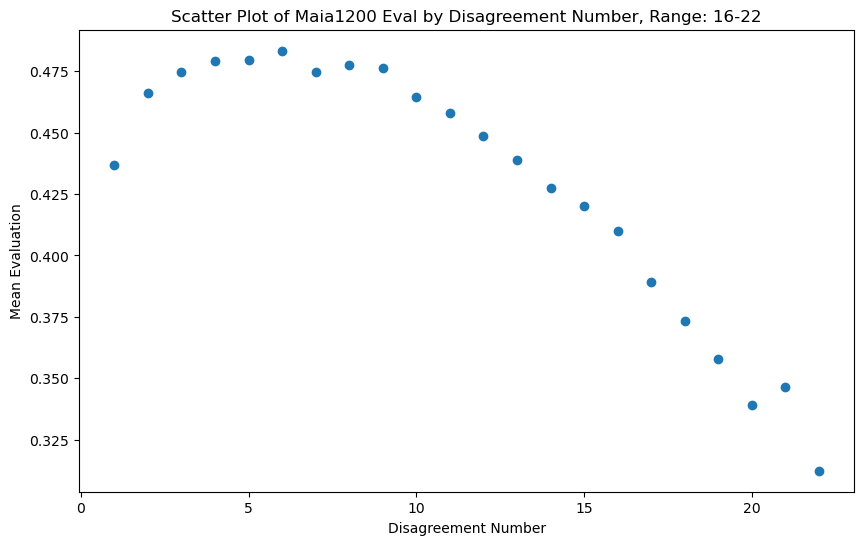

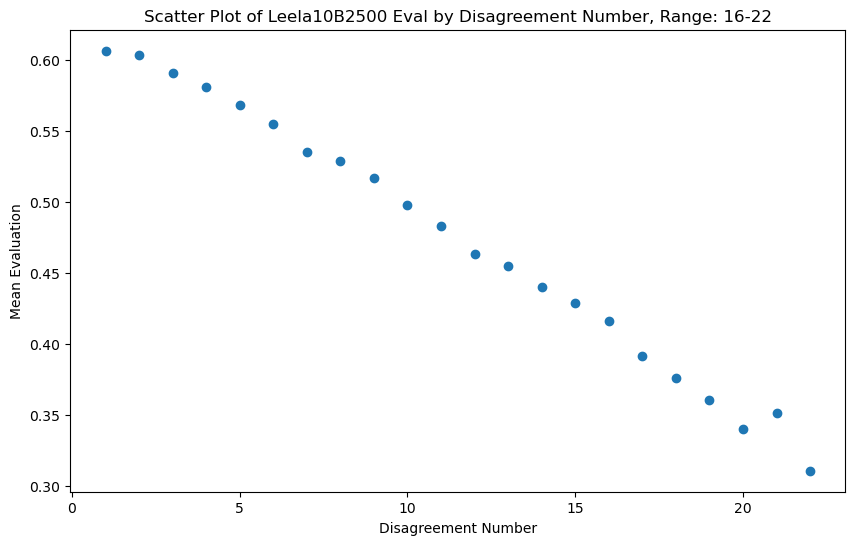

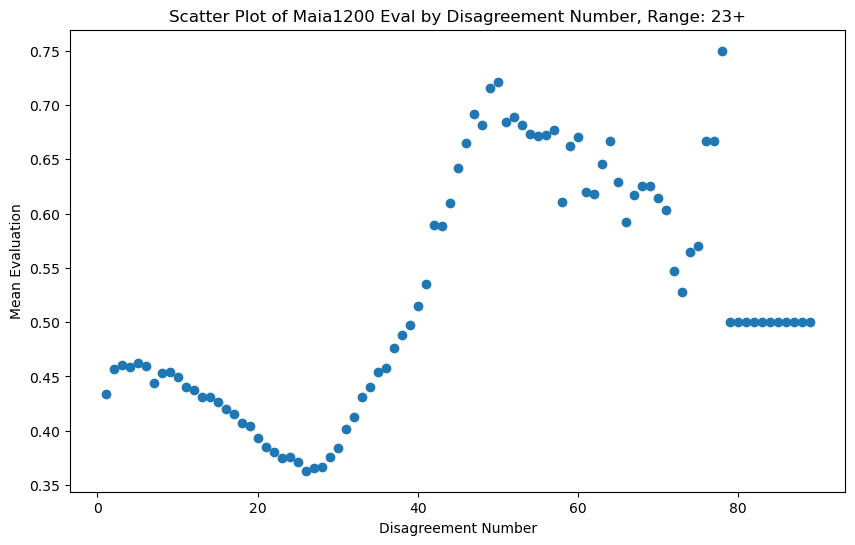

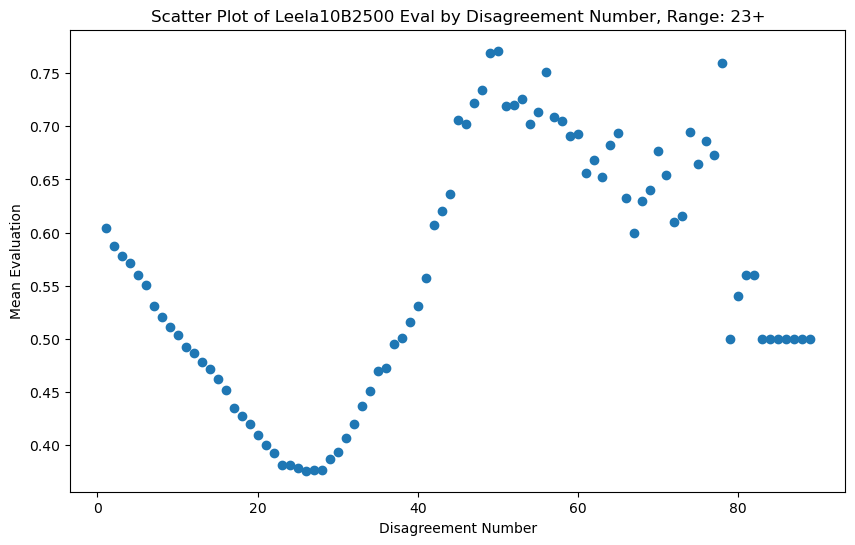

In [48]:
df_range_0_15 = disagreement_df[disagreement_df['dis_in_game'] <= 15]
df_range_16_22 = disagreement_df[disagreement_df['dis_in_game'] <= 22]
df_range_16_22 = df_range_16_22[disagreement_df['dis_in_game'] > 15]
df_range_23_plus = disagreement_df[disagreement_df['dis_in_game'] >= 23]
for df in [(df_range_0_15, "0-15"), (df_range_16_22, "16-22"), (df_range_23_plus, "23+")]:
    for eval_column in ['maia1200_eval', 'leela10b2500_eval']:
        mean_evaluation_by_move = df[0].groupby('dis_num')[eval_column].mean().reset_index()
        plt.figure(figsize=(10, 6))
        plt.scatter(mean_evaluation_by_move['dis_num'], mean_evaluation_by_move[eval_column])
        plt.title(f"Scatter Plot of {eval_column.replace('_', ' ').title()} by Disagreement Number, Range: {df[1]}")
        plt.xlabel('Disagreement Number')
        plt.ylabel('Mean Evaluation')

Text(0, 0.5, 'Mean Confidence')

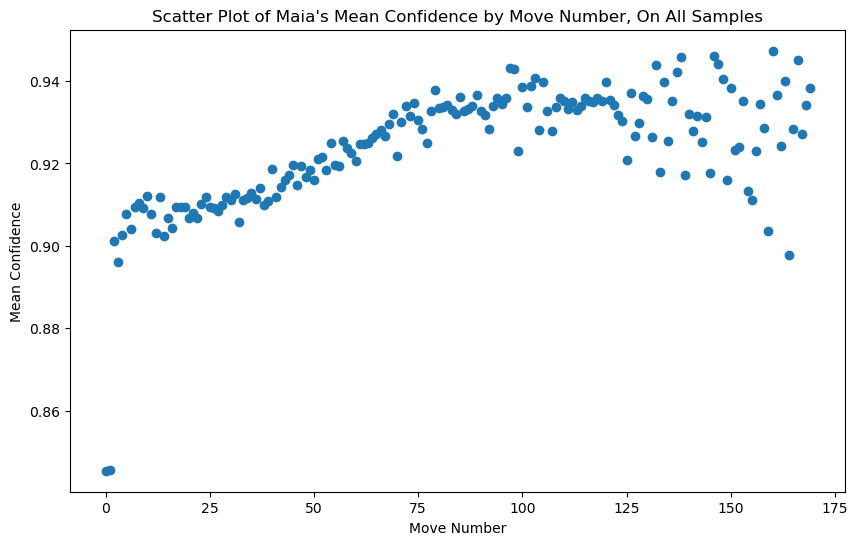

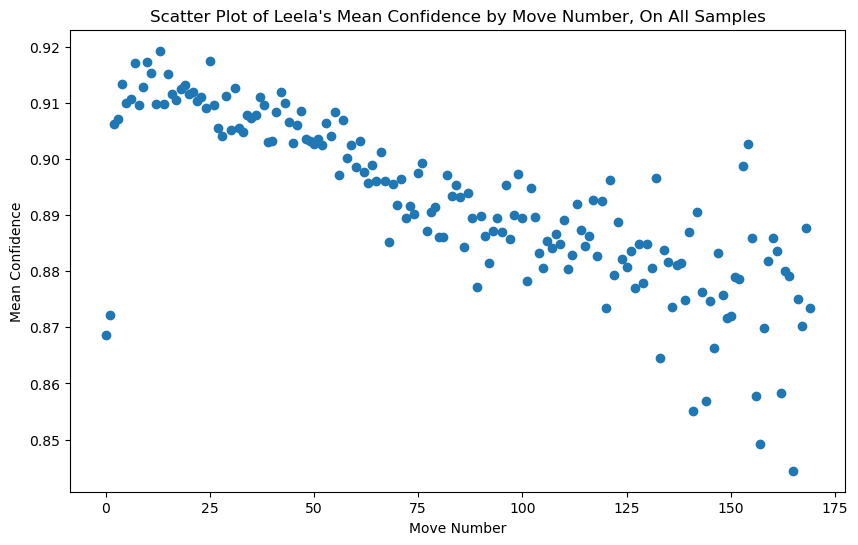

In [49]:
mean_evaluation_by_move = games_df.groupby('ply')['maia1200_conf'].mean().reset_index()
mean_evaluation_by_move = mean_evaluation_by_move[mean_evaluation_by_move['ply'] < 170]
plt.figure(figsize=(10, 6))
plt.scatter(mean_evaluation_by_move['ply'], mean_evaluation_by_move['maia1200_conf'], label="Maia's Confidence")
plt.title("Scatter Plot of Maia's Mean Confidence by Move Number, On All Samples")
plt.xlabel('Move Number')
plt.ylabel('Mean Confidence')
mean_evaluation_by_move = games_df.groupby('ply')['leela10b2500_conf'].mean().reset_index()
mean_evaluation_by_move = mean_evaluation_by_move[mean_evaluation_by_move['ply'] < 170]
plt.figure(figsize=(10, 6))
plt.scatter(mean_evaluation_by_move['ply'], mean_evaluation_by_move['leela10b2500_conf'], label="Leela's Confidence")
plt.title("Scatter Plot of Leela's Mean Confidence by Move Number, On All Samples")
plt.xlabel('Move Number')
plt.ylabel('Mean Confidence')

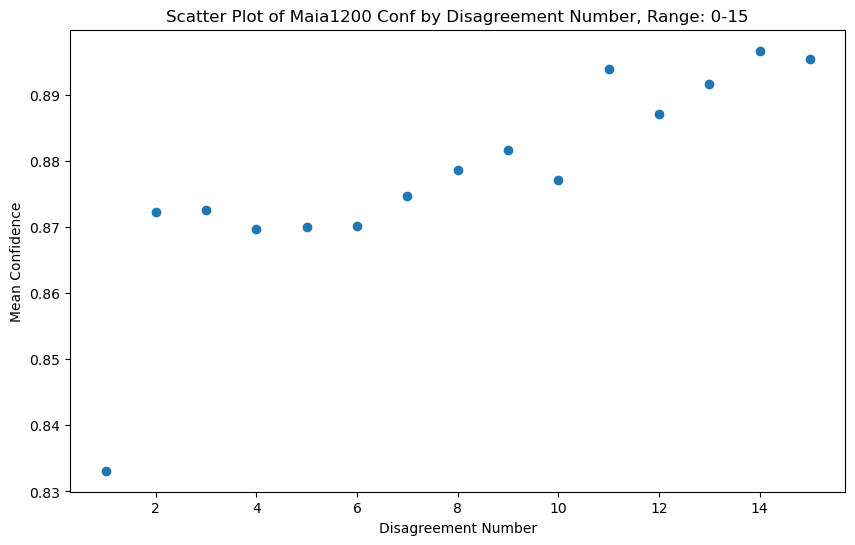

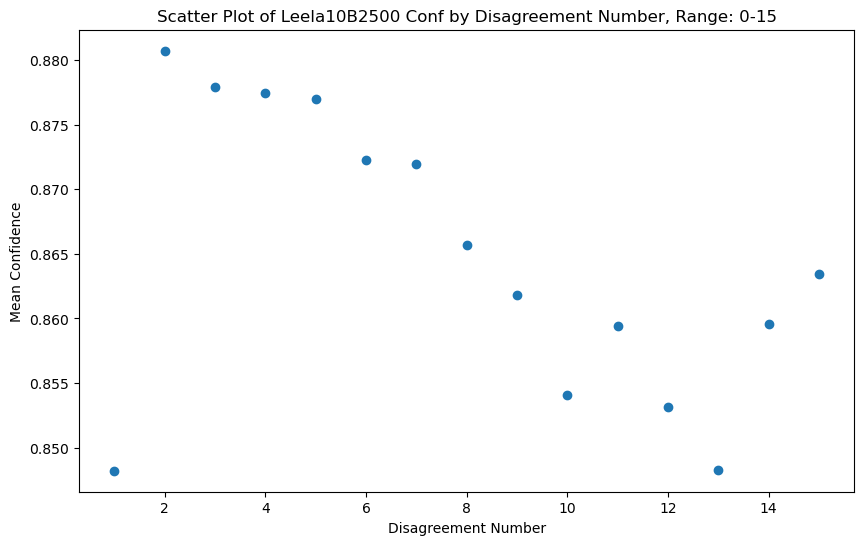

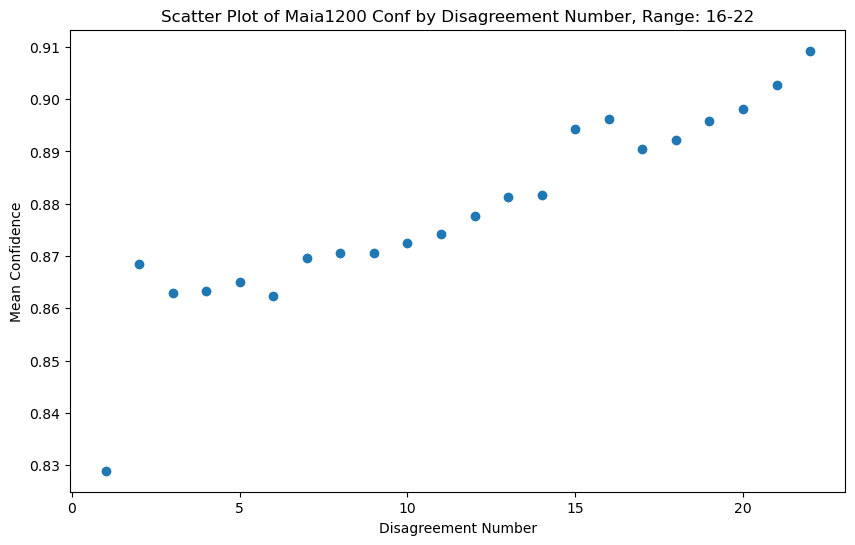

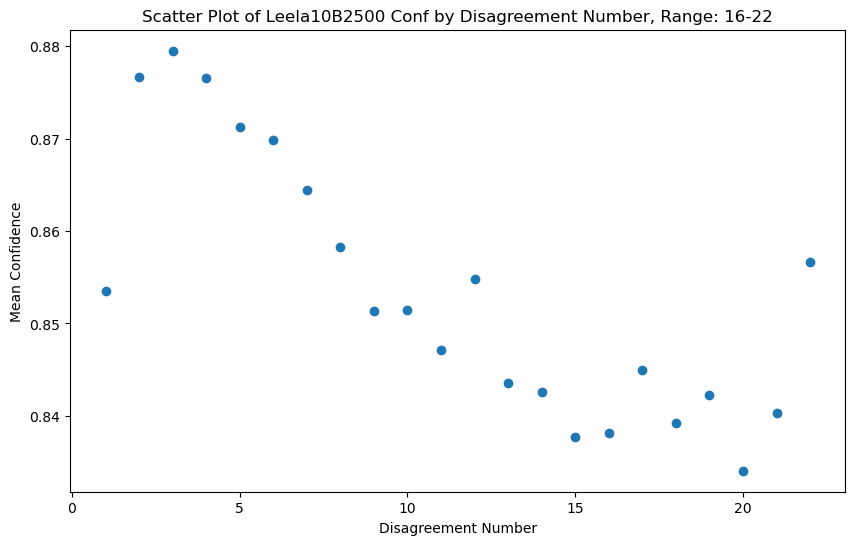

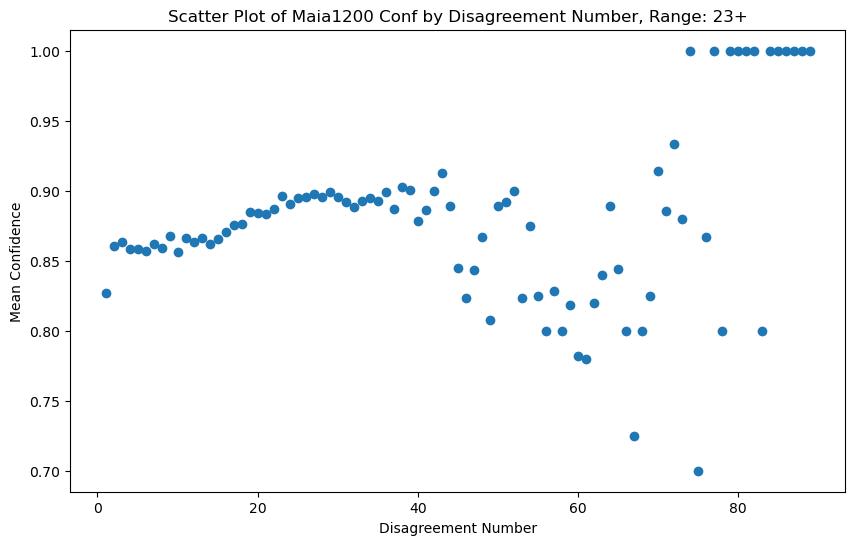

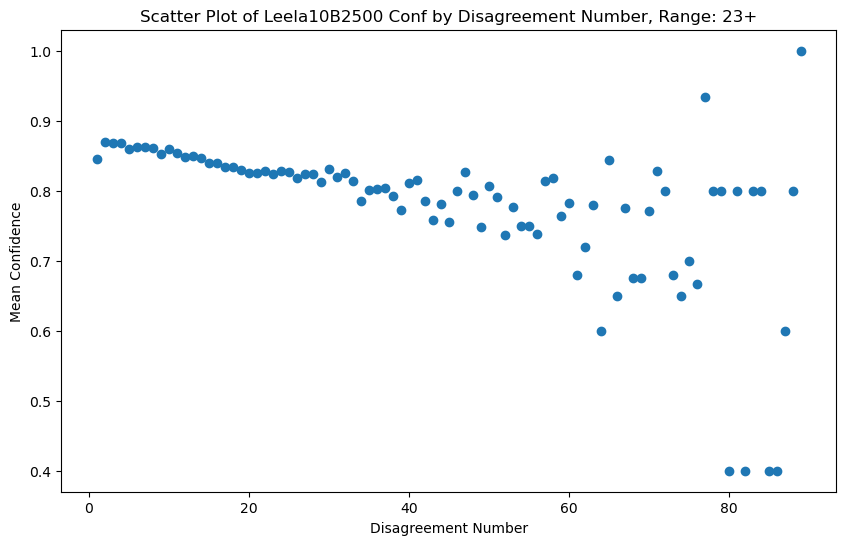

In [50]:
for df in [(df_range_0_15, "0-15"), (df_range_16_22, "16-22"),
           (df_range_23_plus, "23+")]:
      for eval_column in ['maia1200_conf', 'leela10b2500_conf']:
            mean_conf_by_move = df[0].groupby('dis_num')[
                  eval_column].mean().reset_index()
            plt.figure(figsize=(10, 6))
            plt.scatter(mean_conf_by_move['dis_num'],
                        mean_conf_by_move[eval_column],
                        label="Maia's Confidence")
            plt.title(
                  f"Scatter Plot of {eval_column.replace('_', ' ').title()} by Disagreement Number, Range: {df[1]}")
            plt.xlabel('Disagreement Number')
            plt.ylabel('Mean Confidence')

In [51]:
print("Mean values of board features when Maia is better:")
for i in range(len(maia_mean_vec_random)):
    print(f"Feature: {board_feature_names[i]}, mean: {maia_mean_vec_random[i].__round__(3)}, var: {maia_var_vec_random[i].__round__(3)}")

Mean values of board features when Maia is better:
Feature: color, mean: 0.506, var: 0.25
Feature: move_num, mean: 44.197, var: 973.445
Feature: legal_moves_player, mean: 29.552, var: 146.788
Feature: legal_moves_opponent, mean: 31.747, var: 117.651
Feature: legal_captures_player, mean: 1.894, var: 2.746
Feature: legal_captures_opponent, mean: 2.15, var: 2.632
Feature: in_check, mean: 0.058, var: 0.055
Feature: check_to_give_player, mean: 0.563, var: 0.246
Feature: check_to_give_opponent, mean: 0.612, var: 0.237
Feature: queen_threatened_player, mean: 0.063, var: 0.059
Feature: queen_threatened_opponent, mean: 0.022, var: 0.022
Feature: castling_rights_player, mean: 0.039, var: 0.038
Feature: castling_rights_opponent, mean: 0.06, var: 0.056
Feature: enough_material_to_win_player, mean: 0.01, var: 0.01
Feature: enough_material_to_win_opponent, mean: 0.005, var: 0.005
Feature: number_pieces_player, mean: 9.123, var: 11.675
Feature: number_pieces_opponent, mean: 9.102, var: 12.389
Feature

In [52]:
print("Mean values of board features when Leela is better:")
for i in range(len(mean_vec_leela)):
    print(f"Feature: {board_feature_names[i]}, mean: {leela_mean_vec_random[i].__round__(3)}, var: {leela_var_vec_random[i].__round__(3)}")

Mean values of board features when Leela is better:
Feature: color, mean: 0.519, var: 0.25
Feature: move_num, mean: 36.44, var: 1012.772
Feature: legal_moves_player, mean: 31.398, var: 126.141
Feature: legal_moves_opponent, mean: 33.046, var: 103.312
Feature: legal_captures_player, mean: 2.034, var: 2.683
Feature: legal_captures_opponent, mean: 2.223, var: 2.544
Feature: in_check, mean: 0.045, var: 0.043
Feature: check_to_give_player, mean: 0.509, var: 0.25
Feature: check_to_give_opponent, mean: 0.531, var: 0.249
Feature: queen_threatened_player, mean: 0.059, var: 0.055
Feature: queen_threatened_opponent, mean: 0.021, var: 0.021
Feature: castling_rights_player, mean: 0.06, var: 0.056
Feature: castling_rights_opponent, mean: 0.086, var: 0.079
Feature: enough_material_to_win_player, mean: 0.002, var: 0.002
Feature: enough_material_to_win_opponent, mean: 0.006, var: 0.006
Feature: number_pieces_player, mean: 10.144, var: 12.337
Feature: number_pieces_opponent, mean: 10.104, var: 13.326
Fe

In [53]:
def calculate_mean_of_board_feats(df):
    vector_list = []
    for position in df['position']:
        board_feat_instance = board_features(position)
        extracted_vector = board_feat_instance.extract()
        vector_list.append(extracted_vector)

    vector_array = np.array(vector_list)
    mean_vector = np.mean(vector_array, axis=0)
    var_vector = np.var(vector_array, axis=0)
    return mean_vector, var_vector

In [54]:
games_df["maia_better"] = games_df['maia1200_eval'] > games_df['leela10b2500_eval']
games_df["leela_better"] = games_df['leela10b2500_eval'] > games_df['maia1200_eval']
maia_better_df = games_df[games_df['maia_better'] == True]
leela_better_df = games_df[games_df['leela_better'] == True]
maia_better_df['eval_diff'] = maia_better_df['maia1200_eval'] - maia_better_df['leela10b2500_eval']
leela_better_df['eval_diff'] = leela_better_df['leela10b2500_eval'] - leela_better_df['maia1200_eval']
top_maia_samples = maia_better_df.nlargest(1000, 'eval_diff')
top_leela_samples = leela_better_df.nlargest(1000, 'eval_diff')
top_mean_vec_maia, top_var_vec_maia = calculate_mean_of_board_feats(top_maia_samples)
print("Mean values of board features in the top 1000 moves in favor of Maia:")
for i in range(len(top_mean_vec_maia)):
    print(f"Feature: {board_feature_names[i]}, mean: {top_mean_vec_maia[i].__round__(3)}, var: {top_var_vec_maia[i].__round__(3)}")

/var/folders/c_/fhx1wcfx75v13kxh3lwr6jrc0000gn/T/ipykernel_14876/2983228335.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maia_better_df['eval_diff'] = maia_better_df['maia1200_eval'] - maia_better_df['leela10b2500_eval']
/var/folders/c_/fhx1wcfx75v13kxh3lwr6jrc0000gn/T/ipykernel_14876/2983228335.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leela_better_df['eval_diff'] = leela_better_df['leela10b2500_eval'] - leela_better_df['maia1200_eval']


Mean values of board features in the top 1000 moves in favor of Maia:
Feature: color, mean: 0.483, var: 0.25
Feature: move_num, mean: 42.239, var: 503.104
Feature: legal_moves_player, mean: 31.035, var: 150.144
Feature: legal_moves_opponent, mean: 35.483, var: 92.826
Feature: legal_captures_player, mean: 2.341, var: 3.287
Feature: legal_captures_opponent, mean: 2.724, var: 2.814
Feature: in_check, mean: 0.086, var: 0.079
Feature: check_to_give_player, mean: 0.665, var: 0.223
Feature: check_to_give_opponent, mean: 0.745, var: 0.19
Feature: queen_threatened_player, mean: 0.109, var: 0.097
Feature: queen_threatened_opponent, mean: 0.045, var: 0.043
Feature: castling_rights_player, mean: 0.037, var: 0.036
Feature: castling_rights_opponent, mean: 0.029, var: 0.028
Feature: enough_material_to_win_player, mean: 0.0, var: 0.0
Feature: enough_material_to_win_opponent, mean: 0.0, var: 0.0
Feature: number_pieces_player, mean: 9.177, var: 6.102
Feature: number_pieces_opponent, mean: 9.371, var: 6.

In [55]:
top_mean_vec_leela, top_var_vec_leela = calculate_mean_of_board_feats(top_leela_samples)
print("Mean values of board features in the top 1000 moves in favor of Leela:")
for i in range(len(top_mean_vec_leela)):
    print(f"Feature: {board_feature_names[i]}, mean: {top_mean_vec_leela[i].__round__(3)}, var: {top_var_vec_leela[i].__round__(3)}")

Mean values of board features in the top 1000 moves in favor of Leela:
Feature: color, mean: 0.488, var: 0.25
Feature: move_num, mean: 35.72, var: 485.398
Feature: legal_moves_player, mean: 32.746, var: 129.997
Feature: legal_moves_opponent, mean: 35.594, var: 87.865
Feature: legal_captures_player, mean: 2.466, var: 2.961
Feature: legal_captures_opponent, mean: 2.682, var: 2.731
Feature: in_check, mean: 0.059, var: 0.056
Feature: check_to_give_player, mean: 0.593, var: 0.241
Feature: check_to_give_opponent, mean: 0.648, var: 0.228
Feature: queen_threatened_player, mean: 0.094, var: 0.085
Feature: queen_threatened_opponent, mean: 0.03, var: 0.029
Feature: castling_rights_player, mean: 0.047, var: 0.045
Feature: castling_rights_opponent, mean: 0.062, var: 0.058
Feature: enough_material_to_win_player, mean: 0.0, var: 0.0
Feature: enough_material_to_win_opponent, mean: 0.0, var: 0.0
Feature: number_pieces_player, mean: 10.051, var: 7.456
Feature: number_pieces_opponent, mean: 10.175, var: 

In [56]:
print("Number of Maia better samples: " + str(maia_better_df.shape[0]))
print("Number of Leela better samples: " + str(leela_better_df.shape[0]))

Number of Maia better samples: 42762
Number of Leela better samples: 68797


Now, we'll check the move properties in disagreements, when Maia's move is better, and when Leela's move is better.

In [57]:
move_feats_diss_maia = []
for ind, row in disagreement_df.iterrows():
    board = chess.Board(row['position'])
    move_feats_diss_maia.append(move_features(board, chess.Move.from_uci(row['maia1200_move'])))
vector_array_diss_maia = np.array(move_feats_diss_maia)
mean_vector_diss_maia = np.mean(vector_array_diss_maia, axis=0)
variance_vector_diss_maia = np.var(vector_array_diss_maia, axis=0)
feature_names = {0: "distance", 1: "king approach", 2: "advance/ retreat", 3: "flanking", 4: "pawn", 5: "rook",
                 6: "knight", 7: "bishop", 8: "queen", 9: "king", 10: "check", 11: "capture", 12: "castle"}
print("Maia's move features in disagreements:")
for i, (mean, var) in enumerate(zip(mean_vector_diss_maia, variance_vector_diss_maia)):
    feature_name = feature_names.get(i, f"Feature {i}")
    print(f"{feature_name}: Mean = {mean.__round__(3)}, Variance = {var.__round__(3)}")

Maia's move features in disagreements:
distance: Mean = 1.764, Variance = 1.366
king approach: Mean = -0.557, Variance = 1.735
advance/ retreat: Mean = 0.18, Variance = 0.147
flanking: Mean = 0.794, Variance = 0.164
pawn: Mean = 0.219, Variance = 0.171
rook: Mean = 0.212, Variance = 0.167
knight: Mean = 0.122, Variance = 0.107
bishop: Mean = 0.123, Variance = 0.108
queen: Mean = 0.142, Variance = 0.122
king: Mean = 0.181, Variance = 0.149
check: Mean = 0.11, Variance = 0.098
capture: Mean = 0.159, Variance = 0.134
castle: Mean = 0.007, Variance = 0.007


In [58]:
move_feats_diss_leela = []
for ind, row in disagreement_df.iterrows():
    board = chess.Board(row['position'])
    move_feats_diss_leela.append(
        move_features(board, chess.Move.from_uci(row['leela10b2500_move'])))
vector_array_diss_leela = np.array(move_feats_diss_leela)
mean_vector_diss_leela = np.mean(vector_array_diss_leela, axis=0)
variance_vector_diss_leela = np.var(vector_array_diss_leela, axis=0)
print("Leela's move features in disagreements:")
for i, (mean, var) in enumerate(
        zip(mean_vector_diss_leela, variance_vector_diss_leela)):
    feature_name = feature_names.get(i, f"Feature {i}")
    print(
        f"{feature_name}: Mean = {mean.__round__(3)}, Variance = {var.__round__(3)}")

Leela's move features in disagreements:
distance: Mean = 1.687, Variance = 1.159
king approach: Mean = -0.428, Variance = 1.647
advance/ retreat: Mean = 0.199, Variance = 0.159
flanking: Mean = 0.795, Variance = 0.163
pawn: Mean = 0.21, Variance = 0.166
rook: Mean = 0.219, Variance = 0.171
knight: Mean = 0.107, Variance = 0.095
bishop: Mean = 0.125, Variance = 0.11
queen: Mean = 0.143, Variance = 0.123
king: Mean = 0.196, Variance = 0.158
check: Mean = 0.054, Variance = 0.051
capture: Mean = 0.11, Variance = 0.098
castle: Mean = 0.005, Variance = 0.005


In [59]:
move_feats_maia = []
for ind, row in maia_better_df.iterrows():
    board = chess.Board(row['position'])
    move_feats_maia.append(move_features(board, chess.Move.from_uci(row['maia1200_move'])))
vector_array_maia = np.array(move_feats_maia)
mean_vector_maia = np.mean(vector_array_maia, axis=0)
variance_vector_maia = np.var(vector_array_maia, axis=0)
print("Maia's move features when it's better:")
for i, (mean, var) in enumerate(zip(mean_vector_maia, variance_vector_maia)):
    feature_name = feature_names.get(i, f"Feature {i}")
    print(f"{feature_name}: Mean = {mean.__round__(3)}, Variance = {var.__round__(3)}")

Maia's move features when it's better:
distance: Mean = 1.794, Variance = 1.315
king approach: Mean = -0.539, Variance = 1.812
advance/ retreat: Mean = 0.184, Variance = 0.15
flanking: Mean = 0.785, Variance = 0.169
pawn: Mean = 0.208, Variance = 0.165
rook: Mean = 0.233, Variance = 0.179
knight: Mean = 0.131, Variance = 0.114
bishop: Mean = 0.134, Variance = 0.116
queen: Mean = 0.146, Variance = 0.124
king: Mean = 0.149, Variance = 0.127
check: Mean = 0.093, Variance = 0.084
capture: Mean = 0.153, Variance = 0.129
castle: Mean = 0.006, Variance = 0.006


In [60]:
move_feats_leela = []
for ind, row in maia_better_df.iterrows():
    board = chess.Board(row['position'])
    move_feats_leela.append(move_features(board, chess.Move.from_uci(row['leela10b2500_move'])))
vector_array_leela = np.array(move_feats_leela)
mean_vector_leela = np.mean(vector_array_leela, axis=0)
variance_vector_leela = np.var(vector_array_leela, axis=0)
print("Leela's move features when Maia's move is better:")
for i, (mean, var) in enumerate(zip(mean_vector_leela, variance_vector_leela)):
    feature_name = feature_names.get(i, f"Feature {i}")
    print(f"{feature_name}: Mean = {mean.__round__(3)}, Variance = {var.__round__(3)}")

Leela's move features when Maia's move is better:
distance: Mean = 1.75, Variance = 1.235
king approach: Mean = -0.466, Variance = 1.714
advance/ retreat: Mean = 0.183, Variance = 0.15
flanking: Mean = 0.787, Variance = 0.168
pawn: Mean = 0.216, Variance = 0.169
rook: Mean = 0.24, Variance = 0.182
knight: Mean = 0.116, Variance = 0.103
bishop: Mean = 0.132, Variance = 0.114
queen: Mean = 0.152, Variance = 0.129
king: Mean = 0.145, Variance = 0.124
check: Mean = 0.053, Variance = 0.05
capture: Mean = 0.142, Variance = 0.122
castle: Mean = 0.004, Variance = 0.004


In [61]:
move_feats_maia = []
for ind, row in leela_better_df.iterrows():
    board = chess.Board(row['position'])
    move_feats_maia.append(move_features(board, chess.Move.from_uci(row['maia1200_move'])))
vector_array_maia = np.array(move_feats_maia)
mean_vector_maia = np.mean(vector_array_maia, axis=0)
variance_vector_maia = np.var(vector_array_maia, axis=0)
feature_names = {0: "distance", 1: "king approach", 2: "advance/ retreat", 3: "flanking", 4: "pawn", 5: "rook",
                      6: "knight", 7: "bishop", 8: "queen", 9: "king", 10: "check", 11: "capture", 12: "castle"}
print("Maia's move features when Leela's move is better:")
for i, (mean, var) in enumerate(zip(mean_vector_maia, variance_vector_maia)):
    feature_name = feature_names.get(i, f"Feature {i}")
    print(f"{feature_name}: Mean = {mean.__round__(3)}, Variance = {var.__round__(3)}")

Maia's move features when Leela's move is better:
distance: Mean = 1.777, Variance = 1.279
king approach: Mean = -0.66, Variance = 1.694
advance/ retreat: Mean = 0.146, Variance = 0.125
flanking: Mean = 0.785, Variance = 0.169
pawn: Mean = 0.238, Variance = 0.181
rook: Mean = 0.213, Variance = 0.168
knight: Mean = 0.156, Variance = 0.131
bishop: Mean = 0.151, Variance = 0.128
queen: Mean = 0.127, Variance = 0.111
king: Mean = 0.117, Variance = 0.103
check: Mean = 0.079, Variance = 0.073
capture: Mean = 0.197, Variance = 0.158
castle: Mean = 0.011, Variance = 0.011


In [62]:
move_feats_leela = []
for ind, row in leela_better_df.iterrows():
    board = chess.Board(row['position'])
    move_feats_leela.append(move_features(board, chess.Move.from_uci(row['leela10b2500_move'])))
vector_array_leela = np.array(move_feats_leela)
mean_vector_leela = np.mean(vector_array_leela, axis=0)
variance_vector_leela = np.var(vector_array_leela, axis=0)
feature_names = {0: "distance", 1: "king approach", 2: "advance/ retreat", 3: "flanking", 4: "pawn", 5: "rook",
                      6: "knight", 7: "bishop", 8: "queen", 9: "king", 10: "check", 11: "capture", 12: "castle"}
print("Leela's move features when it's move is better:")
for i, (mean, var) in enumerate(zip(mean_vector_leela, variance_vector_leela)):
    feature_name = feature_names.get(i, f"Feature {i}")
    print(f"{feature_name}: Mean = {mean.__round__(3)}, Variance = {var.__round__(3)}")

Leela's move features when it's move is better:
distance: Mean = 1.759, Variance = 1.11
king approach: Mean = -0.488, Variance = 1.705
advance/ retreat: Mean = 0.183, Variance = 0.15
flanking: Mean = 0.778, Variance = 0.172
pawn: Mean = 0.228, Variance = 0.176
rook: Mean = 0.232, Variance = 0.178
knight: Mean = 0.134, Variance = 0.116
bishop: Mean = 0.145, Variance = 0.124
queen: Mean = 0.146, Variance = 0.124
king: Mean = 0.116, Variance = 0.102
check: Mean = 0.035, Variance = 0.034
capture: Mean = 0.105, Variance = 0.094
castle: Mean = 0.007, Variance = 0.007


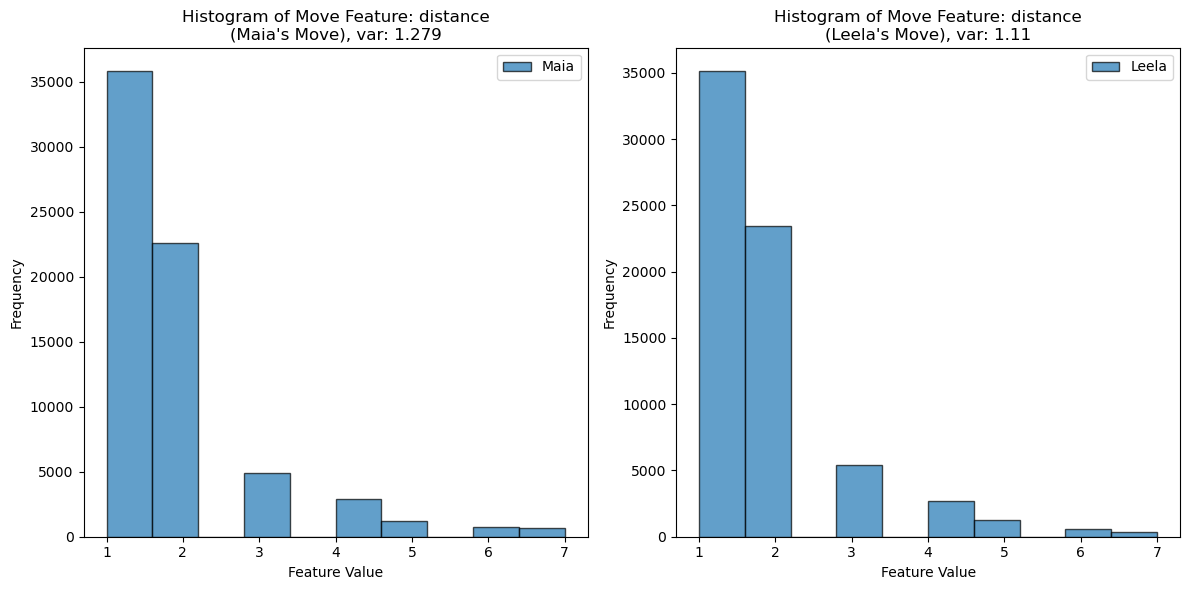

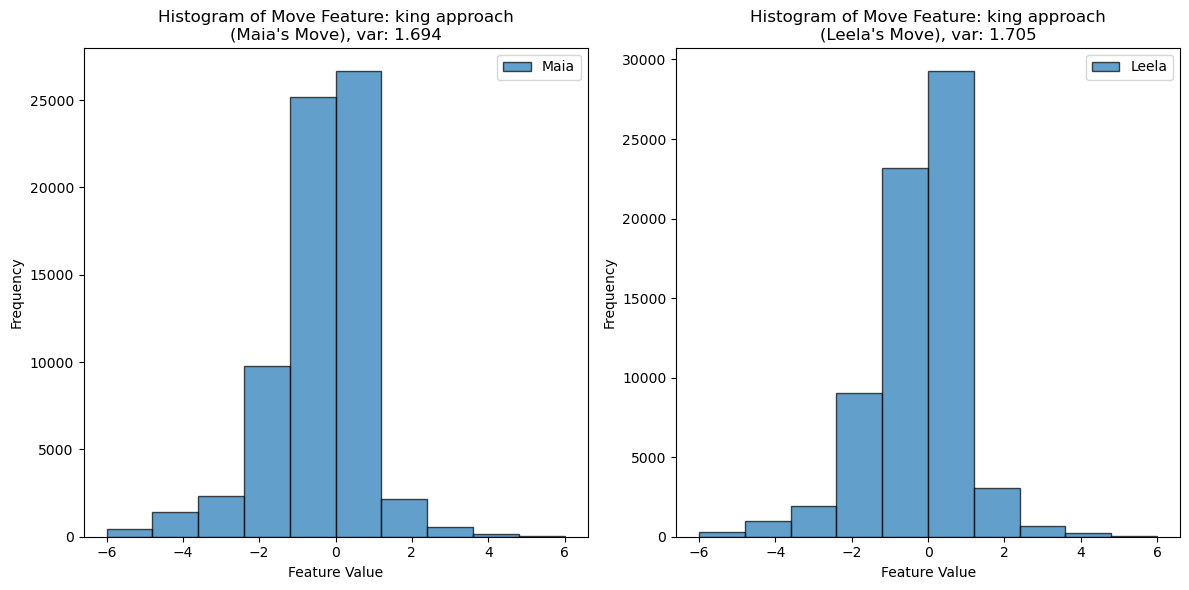

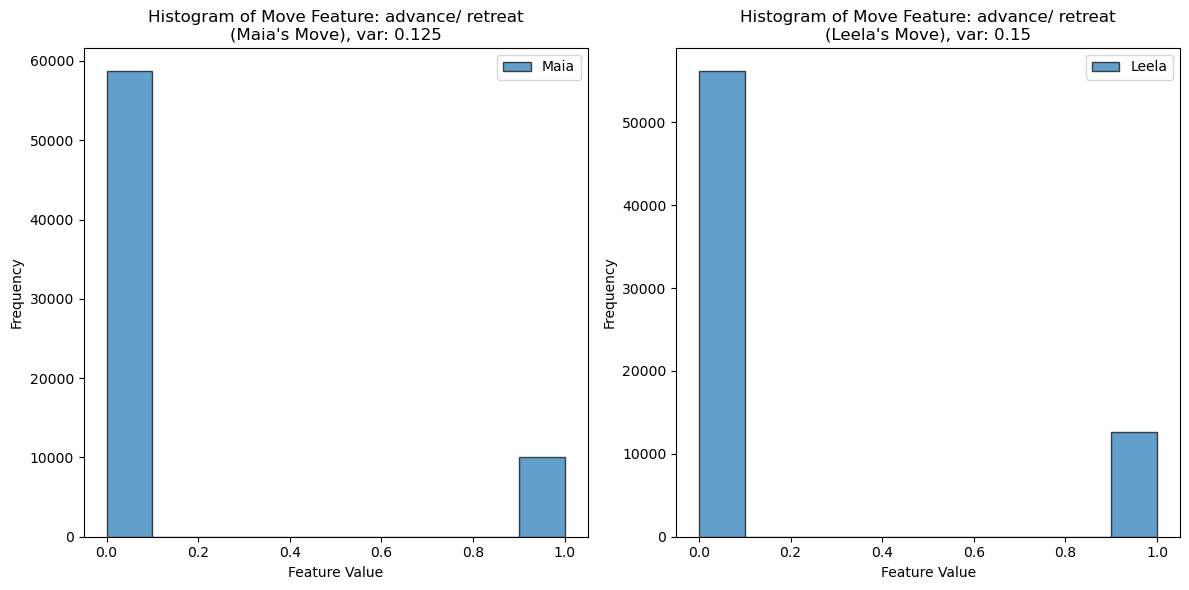

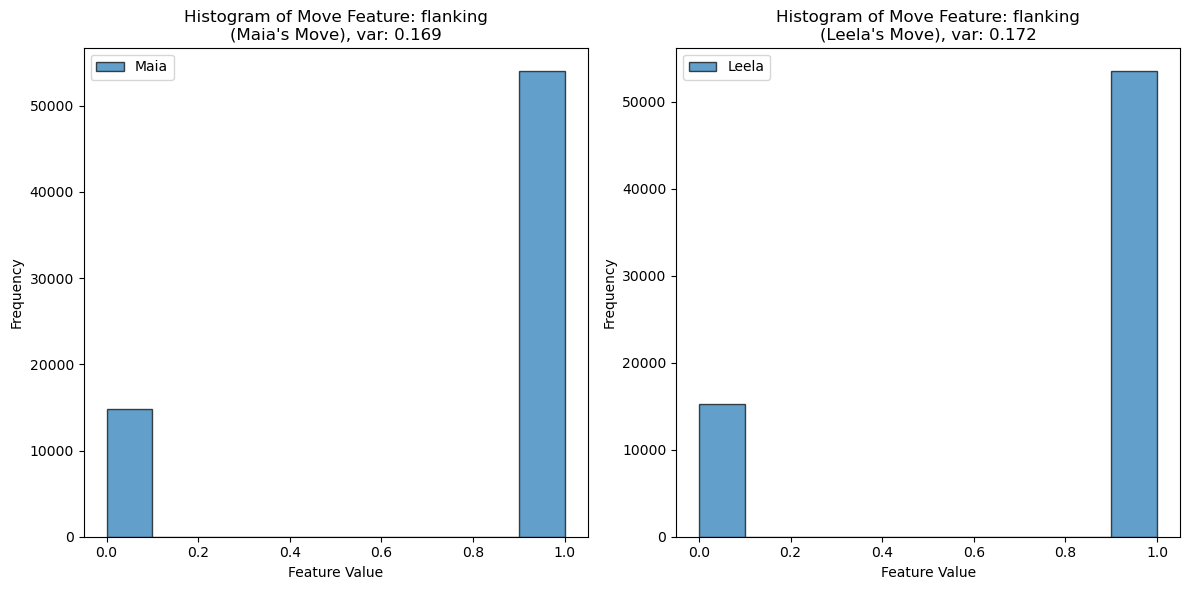

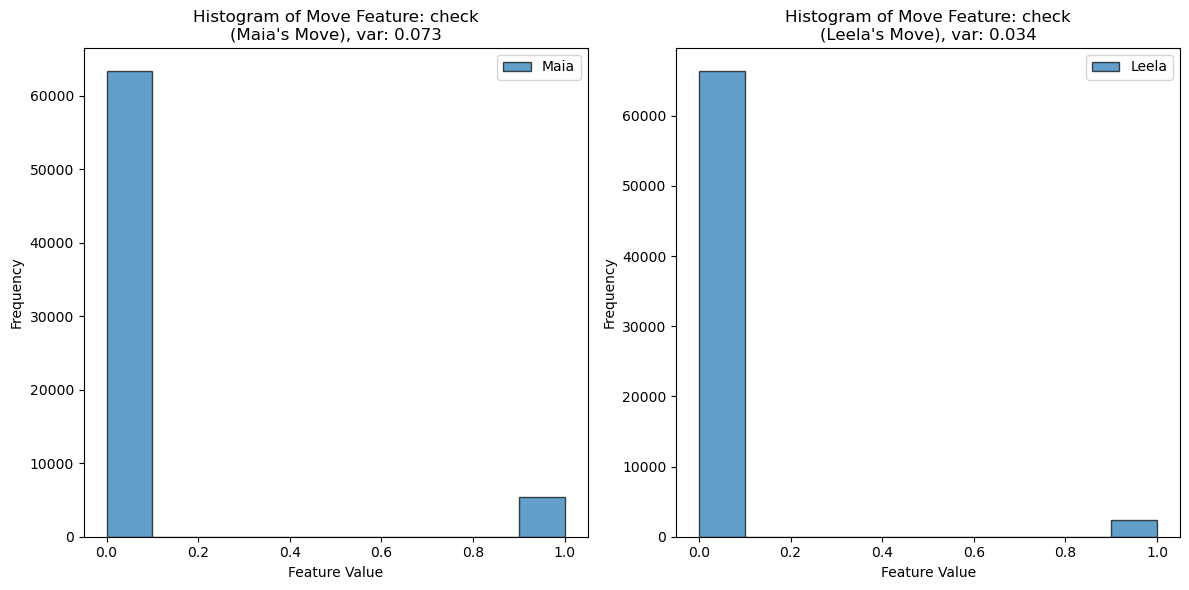

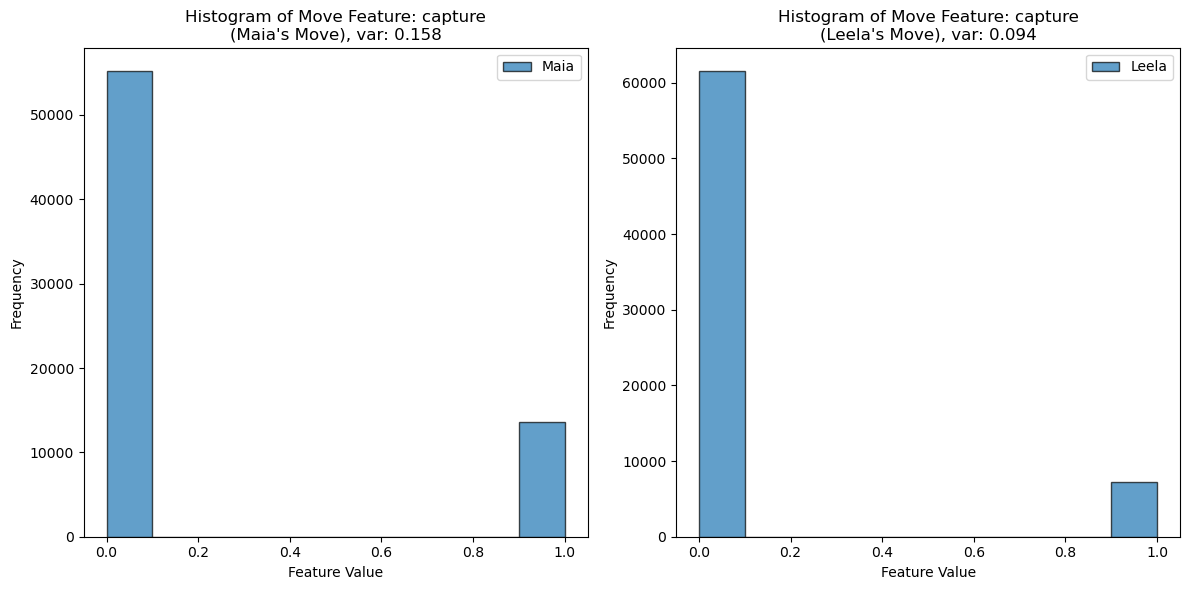

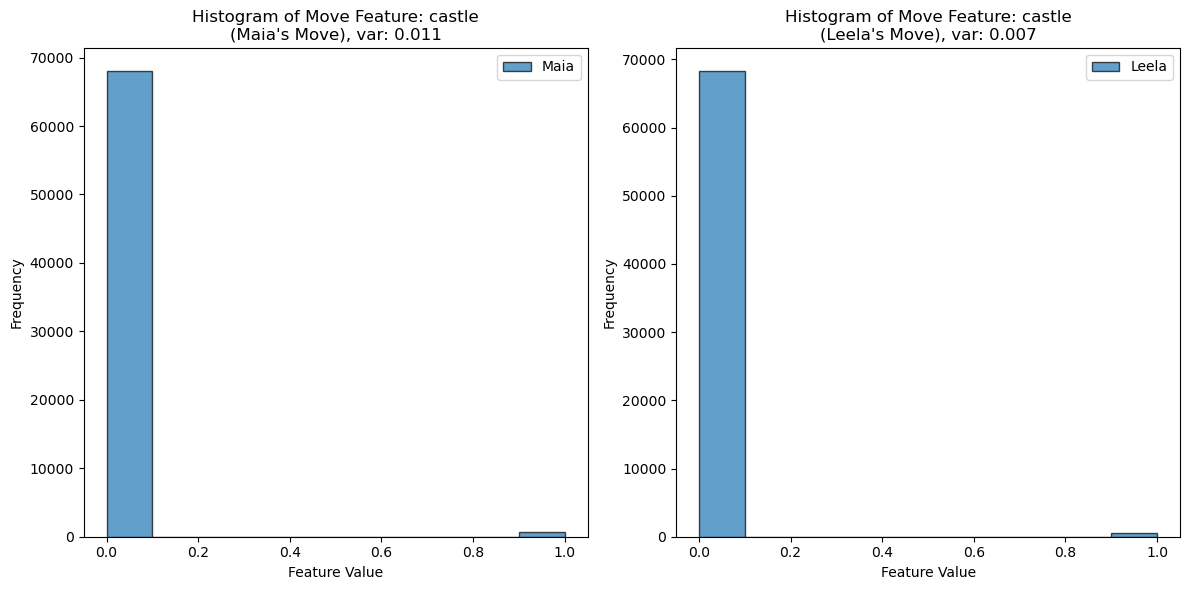

In [63]:
for i in range(vector_array_maia.shape[1]):
    if 4 <= i <= 9:
        continue
    plt.figure(figsize=(12, 6))

    # Create Maia's histogram
    plt.subplot(1, 2, 1)
    plt.hist(vector_array_maia[:, i], bins=10, edgecolor='black', alpha=0.7, label='Maia')
    plt.title(f"Histogram of Move Feature: {feature_names.get(i, f'Feature {i}')}\n(Maia's Move), var: {variance_vector_maia[i].__round__(3)}")
    plt.xlabel("Feature Value")
    plt.ylabel("Frequency")
    plt.legend()

    # Create Leela's histogram
    plt.subplot(1, 2, 2)
    plt.hist(vector_array_leela[:, i], bins=10, edgecolor='black', alpha=0.7, label='Leela')
    plt.title(f"Histogram of Move Feature: {feature_names.get(i, f'Feature {i}')}\n(Leela's Move), var: {variance_vector_leela[i].__round__(3)}")
    plt.xlabel("Feature Value")
    plt.ylabel("Frequency")
    plt.legend()

    plt.tight_layout()
    plt.show()

Now, we'll look for the situations in which the difference between Maia's eval and Leela's eval was the largest in favor of Maia, and check if we can find a pattern.

Color: black, Maia's move: c5c8, Leela's move: c3c2, result: win, Maia's eval: 1.0, Leela's eval: 0.0, Moves to end: [('c8c3', 'agreed'), ('b4d3', 'leela10b2500'), ('d3c5', 'agreed'), ('e6f5', 'leela10b2500'), ('c3e3', 'agreed'), ('e3e1', 'agreed'), ('c5e6', 'agreed'), ('e1g1', 'maia1200'), ('e6g5', 'agreed'), ('g1g3', 'maia1200'), ('g3g2', 'maia1200'), ('g8f7', 'maia1200'), ('f7e6', 'agreed'), ('e6d5', 'agreed'), ('d5c4', 'maia1200'), ('c4c3', 'maia1200'), ('g5f3', 'maia1200'), ('c3b3', 'agreed'), ('g2g1', 'agreed')]


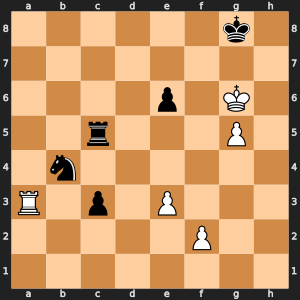

Color: white, Maia's move: c8d8, Leela's move: c8g8, result: lose, Maia's eval: 1.0, Leela's eval: 0.0, Moves to end: [('c2b2', 'agreed'), ('b2a2', 'agreed'), ('a2b1', 'agreed'), ('g8a8', 'agreed'), ('a8a6', 'agreed'), ('a6a2', 'agreed'), ('b1c1', 'agreed'), ('c1d1', 'agreed'), ('d1e1', 'maia1200'), ('e1f1', 'maia1200'), ('f1e1', 'agreed')]


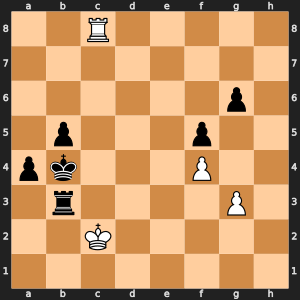

Color: black, Maia's move: d8b6, Leela's move: d8e7, result: win, Maia's eval: 1.0, Leela's eval: 0.0, Moves to end: [('d4c3', 'agreed'), ('c3b3', 'agreed'), ('b3a4', 'agreed'), ('a4b3', 'leela10b2500'), ('a5a4', 'agreed'), ('a4a3', 'agreed'), ('a3a2', 'agreed'), ('a2a1q', 'agreed'), ('b6d8', 'agreed'), ('a1f1', 'leela10b2500'), ('f1c4', 'maia1200'), ('d8g5', 'maia1200'), ('c4d4', 'agreed'), ('d4e5', 'leela10b2500'), ('b3c4', 'leela10b2500'), ('c4c5', 'maia1200'), ('h7g6', 'leela10b2500'), ('e5d6', 'agreed'), ('d6d7', 'agreed'), ('c5c6', 'maia1200'), ('d7b7', 'agreed')]


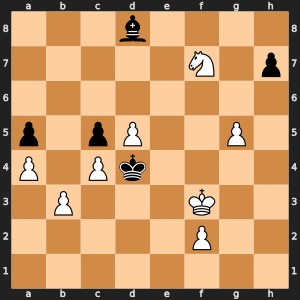

Color: black, Maia's move: f7f6, Leela's move: a1d1, result: lose, Maia's eval: 1.0, Leela's eval: 0.0, Moves to end: []


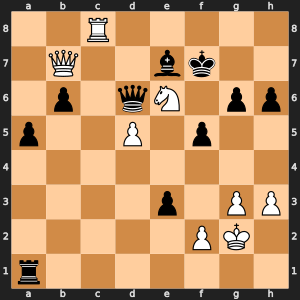

Color: white, Maia's move: d8d5, Leela's move: d8d7, result: lose, Maia's eval: 1.0, Leela's eval: 0.0, Moves to end: [('f2f3', 'agreed'), ('g2h3', 'agreed')]


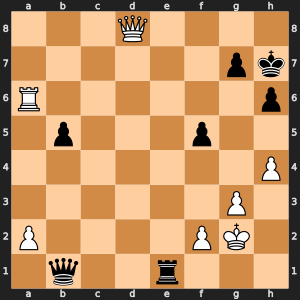

In [64]:
games_df['eval_diff'] = games_df['maia1200_eval'] - games_df['leela10b2500_eval']
top_samples = games_df.nlargest(5, 'eval_diff')
boards = [chess.Board(row['position']) for index, row in top_samples.iterrows()]
for index, row in top_samples.iterrows():
    board = chess.Board(row['position'])
    game_df = games_df[games_df['game'] == row['game']]
    game_df = game_df[game_df['ply'] > row['ply']]
    moves_to_end = []
    for ind, row_ in game_df.iterrows():
        moves_to_end.append((row_['move'], row_['contributor']))
    print(f"Color: {row['color']}, Maia's move: {row['maia1200_move']}, Leela's move: {row['leela10b2500_move']}, result: {row['result']}, Maia's eval: {row['maia1200_eval']}, Leela's eval: {row['leela10b2500_eval']}, Moves to end: {moves_to_end}")
    display(SVG(chess.svg.board(board, size=300)))

In [65]:
maia_1_leela_0 = games_df[games_df['maia1200_eval'] == 1]
maia_1_leela_0 = maia_1_leela_0[maia_1_leela_0['leela10b2500_eval'] == 0]
print(f"Number of situations where Maia has 1 eval and Leela 0: {len(maia_1_leela_0)}")

Number of situations where Maia has 1 eval and Leela 0: 83


The situations in which Leela's eval was much better:

Color: black, Maia's move: h4g3, Leela's move: e5g3, result: lose, Maia's eval: 0.0, Leela's eval: 1.0, Moves to end: [('g3f4', 'leela10b2500'), ('f8g8', 'maia1200'), ('g8g6', 'agreed'), ('g6f6', 'agreed'), ('f4e5', 'agreed'), ('a8a7', 'maia1200'), ('h8g8', 'agreed'), ('f6g6', 'agreed'), ('g8f7', 'agreed'), ('f7f6', 'agreed'), ('f6f7', 'leela10b2500'), ('e5a1', 'leela10b2500'), ('f7e7', 'maia1200'), ('e7f7', 'agreed'), ('a1f6', 'maia1200'), ('f7g7', 'agreed'), ('g7g8', 'agreed'), ('g8g7', 'agreed'), ('g7g8', 'agreed'), ('c7c6', 'maia1200'), ('g8g7', 'agreed'), ('g7g8', 'agreed')]


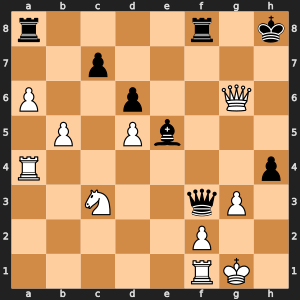

Color: black, Maia's move: c1a3, Leela's move: c1c4, result: lose, Maia's eval: 0.0, Leela's eval: 1.0, Moves to end: [('f7e8', 'agreed'), ('e8d8', 'agreed'), ('a3b2', 'leela10b2500'), ('d8c7', 'agreed'), ('b2f6', 'agreed'), ('f6g5', 'agreed'), ('g5g1', 'leela10b2500'), ('c7b6', 'leela10b2500')]


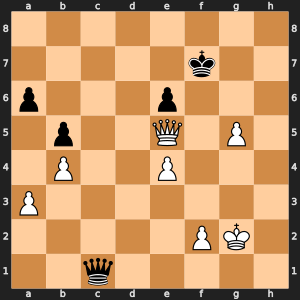

Color: black, Maia's move: b8b7, Leela's move: b8f8, result: win, Maia's eval: 0.0, Leela's eval: 1.0, Moves to end: [('f8f4', 'leela10b2500'), ('c7b8', 'agreed'), ('f4h4', 'agreed'), ('h4d4', 'agreed'), ('h5h4', 'agreed'), ('d4e4', 'agreed'), ('e4e3', 'agreed'), ('h4h3', 'agreed'), ('e3g3', 'leela10b2500'), ('g3h3', 'agreed'), ('h3c3', 'leela10b2500'), ('b8c8', 'agreed'), ('c8c7', 'agreed'), ('c3c1', 'agreed'), ('c7b7', 'maia1200'), ('b7c7', 'agreed'), ('c7c6', 'leela10b2500'), ('c6d5', 'agreed'), ('c1c6', 'leela10b2500'), ('d5d4', 'agreed'), ('d4d3', 'maia1200'), ('d3d4', 'leela10b2500'), ('d4d3', 'maia1200'), ('c6b6', 'leela10b2500'), ('d3c4', 'agreed'), ('b6b7', 'agreed'), ('c4c3', 'agreed'), ('c3c2', 'agreed'), ('b7a7', 'agreed')]


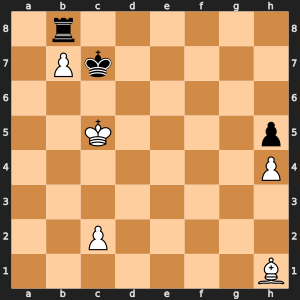

Color: white, Maia's move: d8h8, Leela's move: f7g5, result: lose, Maia's eval: 0.0, Leela's eval: 1.0, Moves to end: [('f7h8', 'agreed'), ('d1d2', 'agreed'), ('c1d1', 'agreed'), ('d1c2', 'agreed'), ('c2d1', 'agreed'), ('d1c1', 'leela10b2500'), ('c1b2', 'leela10b2500'), ('d2d7', 'maia1200'), ('a2a3', 'maia1200'), ('b2a1', 'agreed'), ('a1a2', 'agreed'), ('h4g5', 'maia1200'), ('a2a1', 'agreed'), ('a1a2', 'agreed'), ('a2b2', 'agreed'), ('b2a1', 'agreed'), ('h2h4', 'leela10b2500'), ('a1a2', 'agreed'), ('a3b4', 'agreed')]


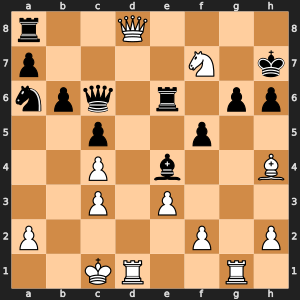

Color: black, Maia's move: g7g2, Leela's move: c8d7, result: lose, Maia's eval: 0.0, Leela's eval: 1.0, Moves to end: [('c8b8', 'agreed'), ('b8a7', 'agreed')]


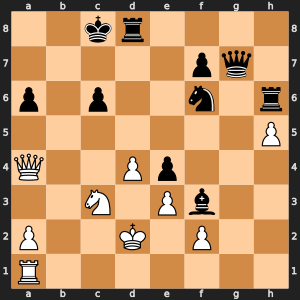

In [66]:
games_df["eval_diff"] = games_df["maia1200_eval"] - games_df["leela10b2500_eval"]
top_samples = games_df.nsmallest(5, 'eval_diff')
boards = [chess.Board(row['position']) for index, row in top_samples.iterrows()]
for index, row in top_samples.iterrows():
    game_df = games_df[games_df['game'] == row['game']]
    game_df = game_df[game_df['ply'] > row['ply']]
    moves_to_end = []
    for ind, row_ in game_df.iterrows():
        moves_to_end.append((row_['move'], row_['contributor']))
    board = chess.Board(row['position'])
    print(f"Color: {row['color']}, Maia's move: {row['maia1200_move']}, Leela's move: {row['leela10b2500_move']}, result: {row['result']}, Maia's eval: {row['maia1200_eval']}, Leela's eval: {row['leela10b2500_eval']}, Moves to end: {moves_to_end}")
    display(SVG(chess.svg.board(board, size=300)))

In [67]:
maia_0_leela_1 = games_df[games_df['maia1200_eval'] == 0]
maia_0_leela_1 = maia_0_leela_1[maia_0_leela_1['leela10b2500_eval'] == 1]
print(f"Number of situations where Maia has 0 eval and Leela 1: {len(maia_0_leela_1)}")

Number of situations where Maia has 0 eval and Leela 1: 52


Pearson Correlation between board features and Maia, Leela scores:


In [68]:
board_feats_disagreements['maia1200_eval'] = disagreement_df['maia1200_eval']
board_feats_disagreements['leela10b2500_eval'] = disagreement_df[
    'leela10b2500_eval']
correlation_matrix_feats = board_feats_disagreements.corr()
for col, series in board_feats_disagreements.iteritems():
    if col not in ['maia1200_eval', 'leela10b2500_eval']:
        print(
            f"Correlation between {col} and Maia score: {correlation_matrix_feats.loc['maia1200_eval', col].__round__(3)}")
        print(
            f"Correlation between {col} and Leela score: {correlation_matrix_feats.loc['leela10b2500_eval', col].__round__(3)}")

Correlation between color and Maia score: 0.009
Correlation between color and Leela score: 0.004
Correlation between move_num and Maia score: -0.01
Correlation between move_num and Leela score: -0.007
Correlation between legal_moves_player and Maia score: 0.007
Correlation between legal_moves_player and Leela score: 0.003
Correlation between legal_moves_opponent and Maia score: 0.003
Correlation between legal_moves_opponent and Leela score: 0.004
Correlation between legal_captures_player and Maia score: -0.002
Correlation between legal_captures_player and Leela score: 0.001
Correlation between legal_captures_opponent and Maia score: 0.008
Correlation between legal_captures_opponent and Leela score: 0.009
Correlation between in_check and Maia score: -0.005
Correlation between in_check and Leela score: -0.003
Correlation between check_to_give_player and Maia score: 0.001
Correlation between check_to_give_player and Leela score: 0.0
Correlation between check_to_give_opponent and Maia scor

/var/folders/c_/fhx1wcfx75v13kxh3lwr6jrc0000gn/T/ipykernel_14876/1572660616.py:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in board_feats_disagreements.iteritems():


Now, we'll check what's the distribution of eval_diff. A positive eval_diff means that the difference is in favor of Maia, negative is in favor of Leela.

/var/folders/c_/fhx1wcfx75v13kxh3lwr6jrc0000gn/T/ipykernel_14876/2739009164.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disagreement_df['eval_diff'] = disagreement_df['maia1200_eval'] - disagreement_df['leela10b2500_eval']


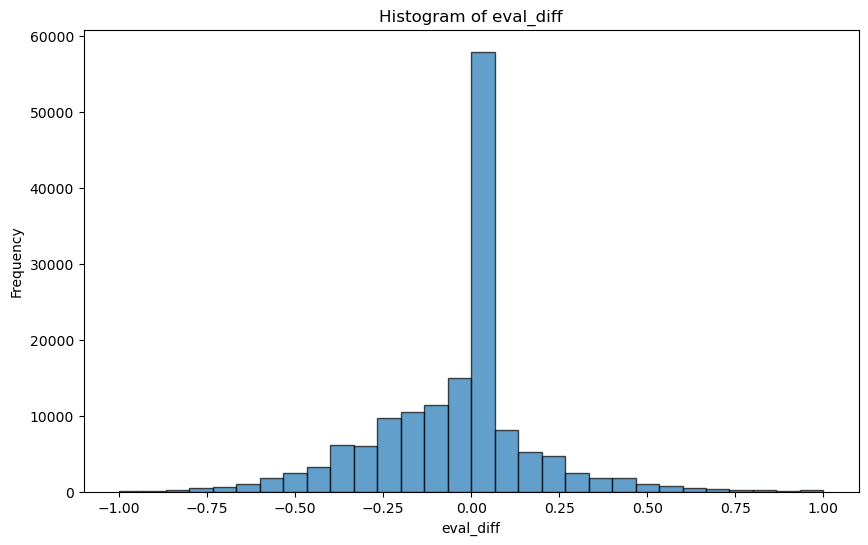

In [69]:
disagreement_df['eval_diff'] = disagreement_df['maia1200_eval'] - disagreement_df['leela10b2500_eval']
val_diff_counts = disagreement_df['eval_diff'].value_counts()
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed

# Specify the number of bins you want (e.g., 20 for more bins)
num_bins = 30

plt.hist(disagreement_df['eval_diff'], bins=num_bins, edgecolor='k', alpha=0.7)
plt.xlabel('eval_diff')
plt.ylabel('Frequency')
plt.title('Histogram of eval_diff')

plt.show()

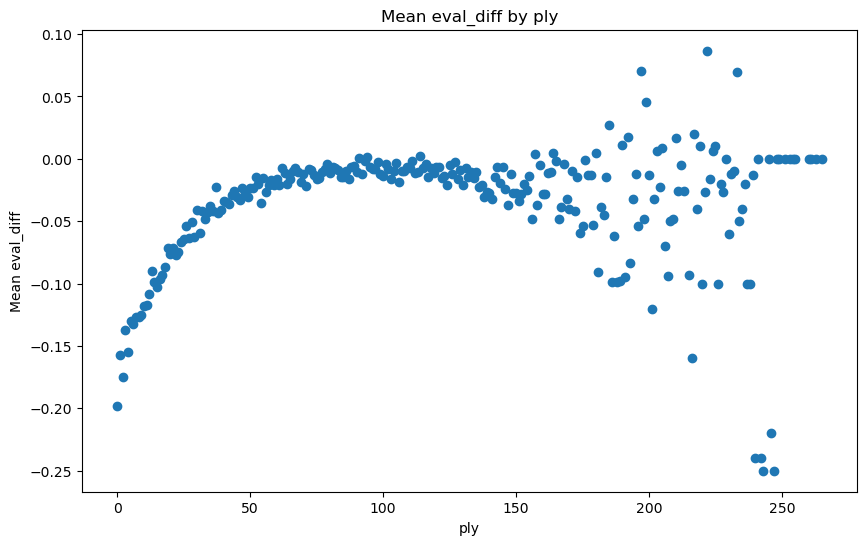

In [70]:
mean_eval_diff_by_ply = disagreement_df.groupby('ply')['eval_diff'].mean().reset_index()
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
plt.plot(mean_eval_diff_by_ply['ply'], mean_eval_diff_by_ply['eval_diff'], marker='o', linestyle='')
plt.xlabel('ply')
plt.ylabel('Mean eval_diff')
plt.title('Mean eval_diff by ply')
plt.show()

In [71]:
board_feats_disagreements['eval_diff'] = disagreement_df['eval_diff']
correlation_matrix_feats = board_feats_disagreements.corr()
for col, series in board_feats_disagreements.iteritems():
    if col not in ['maia1200_eval', 'leela10b2500_eval', 'eval_diff']:
        print(
            f"Correlation between {col} and eval difference: {correlation_matrix_feats.loc['eval_diff', col].__round__(3)}")

Correlation between color and eval difference: 0.008
Correlation between move_num and eval difference: -0.005
Correlation between legal_moves_player and eval difference: 0.006
Correlation between legal_moves_opponent and eval difference: -0.002
Correlation between legal_captures_player and eval difference: -0.006
Correlation between legal_captures_opponent and eval difference: -0.001
Correlation between in_check and eval difference: -0.004
Correlation between check_to_give_player and eval difference: 0.001
Correlation between check_to_give_opponent and eval difference: 0.006
Correlation between queen_threatened_player and eval difference: -0.008
Correlation between queen_threatened_opponent and eval difference: -0.003
Correlation between castling_rights_player and eval difference: -0.003
Correlation between castling_rights_opponent and eval difference: 0.006
Correlation between enough_material_to_win_player and eval difference: -0.003
Correlation between enough_material_to_win_opponent

/var/folders/c_/fhx1wcfx75v13kxh3lwr6jrc0000gn/T/ipykernel_14876/3020660743.py:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in board_feats_disagreements.iteritems():
